# 제주도 버스승차 인원 예측
- ## data 415423 rows × 71 columns
### Columns
- id : 해당 데이터에서의 고유한 id
- data : 날짜
- bus_route_id : 노선 ID
- in_out : 시내버스, 시외버스 구분
- station_code : 해당 승하차 정류소의 id
- station_name : 해당 승하차 정류소의 이름
- latitude : 해당 버스정류장의 위도
- longitude : 해당 버스정류장의 경도
- X-Y_ride : X:00:00 ~ x:59:59까지 승차한 인원 수
- X-Y_takeoff : X:00:00 ~ x:59:59까지 하차한 인원 수
- 18-20_ride : 18:00:00부터 19:59:59까지 승차한 인원 수
- 지번주소 : EDA 및 제주 날씨 merge용 column 
- si :EDA 및 제주 날씨 merge용 column 
- city : EDA 및 제주 날씨 merge용 column  
- dong : EDA 및 제주 날씨 merge용 column  
- road_addr : EDA 및 제주 날씨 merge용 column  
- weather_addr : EDA 및 제주 날씨 merge용 column 
- temperature : 온도
- precipitation : 강수량
- bus_interval : 노선 배차 간격
- date_day : 일 (1일 ~ 30일)
- date_dayofweek : 요일 (0 ~ 6)
- date_dayofname : 요일 (월 ~ 일)
- weekday : 평일 여부
- weekend : 주말 여부
- holiday : 공휴일 여부
- typhoon : 태풍이 온날
- in_ : 시내 버스 구분
- out : 시외 버스 구분
- ridexx : ride(탑승)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- offxx : off(하차)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ride_sum : 승차인원의 합계
- off_sum : 하차인원의 합계
- bus_route_id_sum : 정류소, 일별 운행한 버스노선의 갯수
- bus_route_id_all_sum : 정류소별 9월 전체 운행한 버스노선의 갯수
- dis_jejusi : 해당 정류장의 제주시에서의 거리 ,맞은편 정류장 merge용 컬럼
- dis_seoquipo : 해당 정류장의 서귀포시에서의 거리,맞은편 정류장 merge용 컬럼
- ac_rideX : 맞은편 정류장의 탑승 인원(6시 ~ 11시)
- ac_offX : 맞은편 정류장의 하차 인원(6시 ~ 11시)
- ac_rideXX : 맞은편 정류장의 탑승의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ac_offXX : 맞은편 정류장의 하차의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ac_ride_sum : 맞은편 정류장의 승차인원 합계
- ac_off_sum의 : 맞은편 정류장의 하차인원 합계

# 이슈
    - zero_df로 뺀것은 전체 데이터에서 1개만 있는것들 입니다.
    - 정류장별로 듀플리케이트한것과 안한것과 갯수가 같은것 (토론떄는 zero_df 로 빼자고한것, 약 3700개)은 
    - 따로 예측은 하지않고 train 모델에만 넣는것으로 하였습니다. (사유 : 박사님 피드백)

### 0. 공통

In [1]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pickle
from sklearn.externals import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import count
import plotly_express as px
from tqdm.notebook import tqdm
import geopy.distance
import matplotlib.legend as legend 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA


pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
# matplotlib 설정
mpl.use('Agg')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
pd.set_option('max_columns', 700)
pd.set_option('max_rows', 500)

## 3. 모델 생성, 정규화, 검증, 테스트

#### 01. 데이터 불러오기

In [3]:
#데이터 불러오기
# 415423 rows × 71 columns
raw_data = pd.read_csv('raw_train.csv')
raw_data.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67,ride89,ride1011,off67,off89,off1011,ac_ride67,ac_ride89,ac_ride1011,ac_off67,ac_off89,ac_off1011,ride_sum,ac_ride_sum,off_sum,ac_off_sum,bus_route_id_sum,bus_route_id_all_sum
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.380000,31.873252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 애월읍 애월리 1534-2,제주시,애월읍,애월리,애월로,제주,23.6,22.6,8.0,30,0,Monday,1.0,0.0,0,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5,120
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,27.987818,4.828453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,제주특별자치도 서귀포시 법환동 843,서귀포시,서귀포시,법환동,일주동로,서귀포,24.3,6.3,8.0,30,0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,15,440


#### 02. raw_data를 zero_df와 train, test셋으로 구분하기

In [4]:
# raw_data에서 1회만 운행한 정류장은 zero_df로 빼는 함수
# raw_train = 1회 운행한 정류장이 제외된 train_data
# zero_df = 1회 운행한 정류장의 간략한 정보만 가지고 있는 df(station_code, ride18)
# raw_zero = 1회 운행한 정류장의 df

def make_zero_raw_train(raw_data):
    table = pd.pivot_table(index='station_code', data=raw_data,
                           values='id', aggfunc=len).reset_index()
    table = table[table['id'] == 1]
    raw_train = raw_data.copy()
    raw_zero = pd.DataFrame(columns=raw_data.columns)
    total = tqdm(table['station_code'].unique())
    for i in total:
        raw_train = raw_train[raw_train['station_code'] != i]
        raw_zero = raw_zero.append(raw_data[raw_data['station_code'] == i])
    # zero 모델의 df 생성
    a = raw_zero[['station_code', 'ride18']]
    zero_df = pd.merge(table, a, how='inner')
    return raw_train, zero_df, raw_zero

In [5]:
raw_train, zero_df, raw_zero = make_zero_raw_train(raw_data)

In [6]:
# zero_df를 제외한 raw_train에서 train, test 데이터를 나누는 함수 (중복제거 사용)
def make_train_test(dataframe, category, test_size, random_state):
    # 필수 train 데이터를 만들고
    nec_train = dataframe.drop_duplicates(subset=category)
    # 데이터프레임에서 필수 train을 제외시킨 train_test 셋을 만들고
    train_test = dataframe.drop(dataframe['id'][nec_train['id']])
    X, y = train_test_split(
        train_test, test_size=test_size, random_state=random_state)
    train = pd.concat([nec_train, X])
    return train, y

In [7]:
# 테스트 사이즈가 0.3 정도되야 실제 비율이 7.5:2.5 정도 됩니다.(중복제거된 데이터를 train에 붙이기 때문)
# 만일 카테고리 데이터가 추가된다면 여기에 추가하셔야 합니다.
# 랜덤 스테이트가 바뀌면 테스트 셋이 바뀌니 그냥 진행해주세요
category = ['station_code','bus_route_id', 'in_', 'out', 'weekend', 'weekday', 'holiday', 'typhoon']
df_train, df_test = make_train_test(raw_train, category, 0.3, 13)

In [8]:
# test와 train의 비율 및 정류소의 갯수 (둘다 동일하게 들어갔는지.)
print('train의 비율:', len(df_train) / len(raw_train))
print('test의 비율:', len(df_test) / len(raw_train))
print('전체의 정류소 갯수:', len(raw_train['station_code'].unique()))
print('전체의 노선 갯수:', len(raw_train['bus_route_id'].unique()))
print('train의 정류소 갯수:', len(df_train['station_code'].unique()))
print('test의 정류소 갯수:', len(df_test['station_code'].unique()))
print('train의 노선 갯수:', len(df_train['bus_route_id'].unique()))
print('test의 노선 갯수:', len(df_test['bus_route_id'].unique()))

train의 비율: 0.7682769447092928
test의 비율: 0.2317230552907072
전체의 정류소 갯수: 3472
전체의 노선 갯수: 613
train의 정류소 갯수: 3472
test의 정류소 갯수: 3197
train의 노선 갯수: 613
test의 노선 갯수: 574


#### 03. Scale 하기

In [9]:
# 데이터 스케일링
# 실수형 데이터가 추가되면 아래 values에 추가하면 됩니다.
values = ['ride6', 'ride7', 'ride8', 'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8',
          'off9', 'off10', 'off11', 'ride18', 'temperature', 'precipitation', 'bus_interval',
          'ride67', 'ride89', 'ride1011', 'off67', 'off89', 'off1011',
          'ac_ride6', 'ac_ride7', 'ac_ride8', 'ac_ride9', 'ac_ride10', 'ac_ride11',
          'ac_off6', 'ac_off7', 'ac_off8', 'ac_off9', 'ac_off10', 'ac_off11',
          'ac_ride67', 'ac_ride89', 'ac_ride1011', 'ac_off67', 'ac_off89', 'ac_off1011',
          'ride_sum', 'ac_ride_sum', 'off_sum', 'ac_off_sum', 'bus_route_id_sum', 'bus_route_id_all_sum']

scale_values = [f'scale_{value}' for value in values]

df_train[scale_values] = df_train[values]  # train_data
df_test[scale_values] = df_test[values]  # test_data
raw_zero[scale_values] = raw_zero[values]  # zero_df

X = df_train[scale_values]
Y = df_test[scale_values]
Z = raw_zero[scale_values]

scaler = StandardScaler()
scaler.fit(X)

X_scaler = scaler.transform(X)
Y_scaler = scaler.transform(Y)
Z_scaler = scaler.transform(Z)

df_train[scale_values] = X_scaler
df_test[scale_values] = Y_scaler
raw_zero[scale_values] = Z_scaler

#### 04. 검증모델 만들기

In [10]:
# split 데이터 검증용
# train + validation data를 받아서 임의의 정류장 갯수를 가져옴
def split(df_train, num, seed):
    
    test_frame = pd.DataFrame(columns=df_train.columns)
    np.random.seed(seed)

    for i in np.random.choice(df_train['station_code'].unique(), num, replace=False):
        df1 = df_train[df_train['station_code'] == i]
        test_frame = pd.concat([test_frame, df1])
    return test_frame


# 데이터 검증용 함수
# df_train(or test_frame)를 train_df(학습)와 validation_df(검주ㅡㅇ)를 만듬
# train에는 중복제거된 데이터가 포함되어있음
# train과 validation을 나누는 과정에서 random_state를 다르게 주면 데이터가 바뀜(Kfold와 비슷한 효과)
def make_train_validation(dataframe, cate, test_size, seed):
    train_df = pd.DataFrame(columns=dataframe.columns)
    validation_df = pd.DataFrame(columns=dataframe.columns)
    total = tqdm(dataframe['station_code'].unique())
    print('make_train_validation 실행중....')
    for i in total:
        df1 = dataframe[dataframe['station_code'] == i]
        # 필수 train 데이터를 만들고
        nec_train = df1.drop_duplicates(subset=cate)
        # 필수 train 데이터를 제외한 train_validation을 만듬
        train_validation = df1.drop(df1['id'][nec_train['id']])
        # 만약 필수 train데이터와 train_validation의 크기가 같다(모두 고윳값이다)면
        if len(nec_train) == len(df1):
            #그냥 모두 train_df에 넣음,(validation에는 넣지않음, 박사님 피드백)
            train_df = pd.concat([train_df, nec_train])

        # 만약 train_validation의 갯수가 1이하면, train_validation은 바로 validation이 됨       
        elif len(train_validation) <= 1:
            # train_df와
            train_df = pd.concat([train_df, nec_train])
            # validation_df를 생성함
            validation_df = pd.concat([validation_df, train_validation])
        # 그 외에는 필수 train + train , validation 으로 나눠줌
        else:
            X, y = train_test_split(
                train_validation, test_size=test_size, random_state=seed)
            train_a = pd.concat([nec_train, X])
            train_df = pd.concat([train_df, train_a])
            validation_df = pd.concat([validation_df, y])
    return train_df, validation_df

# 검증 모델
# 만일 validation_df의 station_code가 없다면 학습만하고 예측을 하지 않음
def ols_validation(train_df, validation_df, var, cate):
    
    total = tqdm(train_df['station_code'].unique())
    columns = train_df.columns
    df_tr = pd.DataFrame(columns=columns)
    df_te = pd.DataFrame(columns=columns)
    df_tr['yhat'] = 999
    df_te['yhat'] = 999
    cate_c = [f"C({name})" for name in cate]
    y = ['scale_ride18']
    print('ols_validation 실행중....')
    for i in total:
        train_ols = train_df[train_df['station_code'] == i]
        validation_ols = validation_df[validation_df['station_code'] == i]
    
        if len(validation_ols) ==0:
            model = sm.OLS.from_formula(
            'scale_ride18  ~ ' + '+'.join(var)
            + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit()
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])

        else :
            model = sm.OLS.from_formula(
            'scale_ride18  ~ ' + '+'.join(var)
            + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit()
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])
            
            validation_ols_df = validation_ols[var+cate]  # 테스트 모델
            validation_ols['yhat'] = result.predict(validation_ols_df)
            df_te = pd.concat([df_te, validation_ols])
    return df_tr, df_te

# R스퀘어 구하기
# 앞에서 train과 validation 분리한 seed를 넣어 어떤 seed가 어떤 결정계수가 나왔는지 확인한다.
# DataFrame형태로 반환
def get_rsquared(df_tr, df_te, seed):

    df_tr['residual'] = df_tr['scale_ride18'] - df_tr['yhat']
    df_tr['explained'] = df_tr['yhat'] - np.mean(df_tr['yhat'])
    df_tr['total'] = df_tr['scale_ride18'] - np.mean(df_tr['scale_ride18'])

    df_te['residual'] = df_te['scale_ride18'] - df_te['yhat']
    df_te['explained'] = df_te['yhat'] - np.mean(df_te['yhat'])
    df_te['total'] = df_te['scale_ride18'] - np.mean(df_te['scale_ride18'])

    train_ess = np.sum((df_tr['explained'] ** 2))
    train_rss = np.sum((df_tr['residual'] ** 2))
    train_tss = np.sum((df_tr['total'] ** 2))
    test_ess = np.sum((df_te['explained'] ** 2))
    test_rss = np.sum((df_te['residual'] ** 2))
    test_tss = np.sum((df_te['total'] ** 2))

    rsquared = {'seed': [f'{seed}'],
             'train_rsquared': [1-train_rss/train_tss],
             'validation_rsquared': [1-test_rss/test_tss]}
    print(f'seed : {seed} 완료')
    return pd.DataFrame(rsquared)

In [11]:
# 한번에 여러번 해보기
# 위에서 만든 make_train_validation -> ols_validation -> get_rsquared의 순서를 거침
# 시드를 리스트로 받아서
# dataframe = (train과 validation으로 나누기 전의 데이터)
# seeds = 리스트형태의 seed 목록 (갯수만큼 ols를 검증함)
# test_size = validation_size, 왠만하면 0.2로 고정해주세요
# 리턴되는 rsquared_df 데이터 프레임에 train, validation의 결정계수, ess, rss, tss, RMSE를 seed 별로 데이터프레임으로 만들어줍니다.

def validations(dataframe, seeds, test_size):
    basic = ['scale_ride18', 'station_code', 'id']
    dataframe = dataframe[basic + var + cate]
    rsquared_df = pd.DataFrame()
    for seed in seeds:
        train_df, validation_df = make_train_validation(dataframe, cate, test_size, seed)
        df_tr, df_te = ols_validation(train_df, validation_df, var, cate)
        rsquared = get_rsquared(df_tr, df_te, seed)
        rsquared_df = pd.concat([rsquared_df, rsquared])
    return rsquared_df

In [12]:
# 0.0.2 ver 추가 버전
# 상위 num번째의 데이터 만드는 함수

def make_top_station(num):
    table_raw = pd.pivot_table(raw_data, index='station_code', values='id', aggfunc=len,)
    top = raw_data['station_code'].value_counts()[:num]
    top_df = pd.DataFrame(top).reset_index()
    top_df.columns = ['station_code', 'count']
    print(f'상위 정류장 {num}개는 전체 3563개의 정류소 중', round(top_df['count'].sum() / len(raw_data) * 100,1),'%를 대표합니다.')

    dataframe = pd.DataFrame()
    total = tqdm(top_df['station_code'].unique())
    for i in total:
        dataframe = dataframe.append(df_train[df_train['station_code'] == i])
    return dataframe

In [13]:
# 상위 정류장 100개 만들고
# 전체 3563개의  정류장 중 상위 100개의 정류장이 전체 데이터의 약 22% 이상을 차지 함
dataframe_100 = make_top_station(100)

상위 정류장 100개는 전체 3563개의 정류소 중 22.0 %를 대표합니다.


In [14]:
# 여기서 변수 변경해가면서 검증해보세요
var_total = ['scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
             'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',
             'scale_temperature', 'scale_precipitation', 'scale_bus_interval', 
             'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
             'scale_ac_ride6', 'scale_ac_ride7', 'scale_ac_ride8', 'scale_ac_ride9', 'scale_ac_ride10', 'scale_ac_ride11',
             'scale_ac_off6', 'scale_ac_off7', 'scale_ac_off8', 'scale_ac_off9', 'scale_ac_off10', 'scale_ac_off11',
             'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011',
             'scale_ride_sum', 'scale_ac_ride_sum', 'scale_off_sum', 'scale_ac_off_sum',
             'scale_bus_route_id_sum','scale_bus_route_id_all_sum']

# 'scale_ride67','scale_ride89','scale_ride1011','scale_off67','scale_off89', 'scale_off1011'
# 는 2시간 더한 컬럼입니다.

# 검증에 필요한 기본 컬럼 입니다.

# 검증에 사용할 실수 변수를 넣으세요
var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_ride_sum', 'scale_off_sum', 'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
       'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011'
       ]
# 'scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
# 'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',

# 검증에 사용할 카테고리 변수를 넣으세요
cate = ['bus_route_id', 'in_', 'out', 'weekend',
        'weekday', 'holiday', 'typhoon']  # ,

seeds = [300, 20, 30, 40, 50]  # 랜덤시드를 주어서 Kfold한 효과를 가져옴
test_size = 0.3  # 변경해도 상관은 없는데 그냥 0.3로 하는게.. 그래야 7.5:2.5 정도 나옵니다.
rsquared_df_100 = validations(dataframe_100, seeds, test_size)
rsquared_df_100

make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


,seed,train_rsquared,validation_rsquared
0,300,0.797009,0.736863
0,20,0.787268,0.763425
0,30,0.789086,0.767753
0,40,0.794473,0.749232
0,50,0.791988,0.748470


In [15]:
# 상위 정류장 500개 만들고
# 전체 3563개의  정류장 중 상위 500개의 정류장이 전체 데이터의 약 57% 이상을 차지 함
dataframe_500 = make_top_station(500)

상위 정류장 500개는 전체 3563개의 정류소 중 57.0 %를 대표합니다.


In [16]:
# 여기서 변수 변경해가면서 검증해보세요
var_total = ['scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
             'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',
             'scale_temperature', 'scale_precipitation', 'scale_bus_interval', 
             'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
             'scale_ac_ride6', 'scale_ac_ride7', 'scale_ac_ride8', 'scale_ac_ride9', 'scale_ac_ride10', 'scale_ac_ride11',
             'scale_ac_off6', 'scale_ac_off7', 'scale_ac_off8', 'scale_ac_off9', 'scale_ac_off10', 'scale_ac_off11',
             'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011',
             'scale_ride_sum', 'scale_ac_ride_sum', 'scale_off_sum', 'scale_ac_off_sum',
             'scale_bus_route_id_sum','scale_bus_route_id_all_sum']

# 'scale_ride67','scale_ride89','scale_ride1011','scale_off67','scale_off89', 'scale_off1011'
# 는 2시간 더한 컬럼입니다.

# 검증에 사용할 실수 변수를 넣으세요
var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_ride_sum', 'scale_off_sum', 'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
       'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011'
       ]
# 'scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
# 'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',

# 검증에 사용할 카테고리 변수를 넣으세요
cate = ['bus_route_id', 'in_', 'out', 'weekend',
        'weekday', 'holiday', 'typhoon']  # ,

seeds = [300, 20, 30, 40, 50]  # 랜덤시드를 주어서 Kfold한 효과를 가져옴
test_size = 0.3  # 변경해도 상관은 없는데 그냥 0.3로 하는게.. 그래야 7.5:2.5 정도 나옵니다.
rsquared_df_500 = validations(dataframe_500, seeds, test_size)
rsquared_df_500

make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


,seed,train_rsquared,validation_rsquared
0,300,0.804455,0.707873
0,20,0.797206,0.734023
0,30,0.797231,0.741431
0,40,0.806893,0.701793
0,50,0.795576,0.743234


In [17]:
# 상위 정류장 1000개 만들고
# 전체 3563개의  정류장 중 상위 1000개의 정류장이 전체 데이터의 약 76% 이상을 차지 함
dataframe_1000 = make_top_station(1000)

상위 정류장 1000개는 전체 3563개의 정류소 중 75.9 %를 대표합니다.


In [18]:
# 여기서 변수 변경해가면서 검증해보세요
var_total = ['scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
             'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',
             'scale_temperature', 'scale_precipitation', 'scale_bus_interval', 
             'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
             'scale_ac_ride6', 'scale_ac_ride7', 'scale_ac_ride8', 'scale_ac_ride9', 'scale_ac_ride10', 'scale_ac_ride11',
             'scale_ac_off6', 'scale_ac_off7', 'scale_ac_off8', 'scale_ac_off9', 'scale_ac_off10', 'scale_ac_off11',
             'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011',
             'scale_ride_sum', 'scale_ac_ride_sum', 'scale_off_sum', 'scale_ac_off_sum',
             'scale_bus_route_id_sum','scale_bus_route_id_all_sum']

# 'scale_ride67','scale_ride89','scale_ride1011','scale_off67','scale_off89', 'scale_off1011'
# 는 2시간 더한 컬럼입니다.

# 검증에 사용할 실수 변수를 넣으세요
var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_ride_sum', 'scale_off_sum', 'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
       'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011'
       ]
# 'scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
# 'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',

# 검증에 사용할 카테고리 변수를 넣으세요
cate = ['bus_route_id', 'in_', 'out', 'weekend',
        'weekday', 'holiday', 'typhoon']  # ,

seeds = [300, 20, 30, 40, 50]  # 랜덤시드를 주어서 Kfold한 효과를 가져옴
test_size = 0.3  # 변경해도 상관은 없는데 그냥 0.3로 하는게.. 그래야 7.5:2.5 정도 나옵니다.
rsquared_df_1000 = validations(dataframe_1000, seeds, test_size)
rsquared_df_1000

make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


,seed,train_rsquared,validation_rsquared
0,300,0.803183,0.668150
0,20,0.795777,0.721104
0,30,0.796014,0.710173
0,40,0.805645,0.681180
0,50,0.794896,0.686109


#### 05. 최적화 찾기

In [19]:
# 검증 모델
# 만일 validation_df의 station_code가 없다면 학습만하고 예측을 하지 않음
def ols_validation_reg(train_df, validation_df, var, cate, alpha, wt):
    
    total = tqdm(train_df['station_code'].unique())
    columns = train_df.columns
    df_tr = pd.DataFrame(columns=columns)
    df_te = pd.DataFrame(columns=columns)
    df_tr['yhat'] = 999
    df_te['yhat'] = 999
    cate_c = [f"C({name})" for name in cate]
    y = ['scale_ride18']
    print('ols_validation 실행중....')
    for i in total:
        train_ols = train_df[train_df['station_code'] == i]
        validation_ols = validation_df[validation_df['station_code'] == i]
    
        if len(validation_ols) ==0:
            model = sm.OLS.from_formula(
            'scale_ride18  ~ ' + '+'.join(var)
            + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit_regularized(alpha=alpha, L1_wt=wt)
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])

        else :
            model = sm.OLS.from_formula(
            'scale_ride18  ~ ' + '+'.join(var)
            + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit_regularized(alpha=alpha, L1_wt=wt)
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])
            
            validation_ols_df = validation_ols[var+cate]  # 테스트 모델
            validation_ols['yhat'] = result.predict(validation_ols_df)
            df_te = pd.concat([df_te, validation_ols])
    return df_tr, df_te

In [20]:
# 최적화 알파값 찾는 함수
def validations_lasso(dataframe, seeds, test_size, alpha):
    rsquared_df = pd.DataFrame()
    for seed in seeds:
        train_df, validation_df = make_train_validation(dataframe, cate, test_size, seed)
        df_tr, df_te = ols_validation_reg(train_df, validation_df, var, cate, alpha, 1)
        rsquared = get_rsquared(df_tr, df_te, seed)
        rsquared_df = pd.concat([rsquared_df, rsquared])
    return rsquared_df


def validations_ridge(dataframe, seeds, test_size, alpha):
    rsquared_df = pd.DataFrame()
    for seed in seeds:
        train_df, validation_df = make_train_validation(dataframe, cate, test_size, seed)
        df_tr, df_te = ols_validation_reg(train_df, validation_df, var, cate, alpha, 0)
        rsquared = get_rsquared(df_tr, df_te, seed)
        rsquared_df = pd.concat([rsquared_df, rsquared])
    return rsquared_df


def validations_elastic(dataframe, seeds, test_size, alpha):
    rsquared_df = pd.DataFrame()
    for seed in seeds:
        train_df, validation_df = make_train_validation(dataframe, cate, test_size, seed)
        df_tr, df_te = ols_validation_reg(train_df, validation_df, var, cate, alpha, 0.5)
        rsquared = get_rsquared(df_tr, df_te, seed)
        rsquared_df = pd.concat([rsquared_df, rsquared])
    return rsquared_df

In [21]:
def get_alpha_value(mini, maxi):
    ls = []
    names = []
    val_scores1 = []
    alphas = []
    count = 0
    basic = ['scale_ride18', 'station_code', 'id']
    for i in np.exp(np.linspace(mini, maxi)):
        count += 1
        print("{}번째 실행중".format(count))
        rsquared_df_lasso = validations_lasso(dataframe_10[basic + var + cate], seeds, test_size, i)
        rsquared_df_ridge = validations_ridge(dataframe_10[basic + var + cate], seeds, test_size, i)
        rsquared_df_elastic = validations_elastic(dataframe_10[basic + var + cate], seeds, test_size, i)
        
        # Validation_rsquared 1의 평균
        avg_las_val1 = (rsquared_df_lasso['validation_rsquared'].sum())/5
        avg_rid_val1 = (rsquared_df_ridge['validation_rsquared'].sum())/5
        avg_ela_val1 = (rsquared_df_elastic['validation_rsquared'].sum())/5
        
        ls.append(("lasso", avg_las_val1,  i))
        ls.append(("ridge", avg_rid_val1, i))
        ls.append(("elastic", avg_ela_val1, i))
        
    for name, val_score1, alpha in ls:
        names.append(name)
        val_scores1.append(val_score1)     
        alphas.append(alpha)
    
    data = {"name": names, "val_score1": val_scores1,  "alpha": alphas} # "val_score2": val_scores2,

    return pd.DataFrame(data)

In [22]:
dataframe_10 = make_top_station(1)

상위 정류장 1개는 전체 3563개의 정류소 중 0.4 %를 대표합니다.


In [23]:
# 여기서 변수 변경해가면서 검증해보세요
var_total = ['scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
             'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',
             'scale_temperature', 'scale_precipitation', 'scale_bus_interval', 
             'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
             'scale_ac_ride6', 'scale_ac_ride7', 'scale_ac_ride8', 'scale_ac_ride9', 'scale_ac_ride10', 'scale_ac_ride11',
             'scale_ac_off6', 'scale_ac_off7', 'scale_ac_off8', 'scale_ac_off9', 'scale_ac_off10', 'scale_ac_off11',
             'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011',
             'scale_ride_sum', 'scale_ac_ride_sum', 'scale_off_sum', 'scale_ac_off_sum',
             'scale_bus_route_id_sum','scale_bus_route_id_all_sum']

# 'scale_ride67','scale_ride89','scale_ride1011','scale_off67','scale_off89', 'scale_off1011'
# 는 2시간 더한 컬럼입니다.

# 검증에 사용할 실수 변수를 넣으세요
var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_ride_sum', 'scale_off_sum', 'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
       'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011'
       ]
# 'scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
# 'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',

# 검증에 사용할 카테고리 변수를 넣으세요
cate = ['bus_route_id', 'in_', 'out', 'weekend', 'weekday', 'holiday', 'typhoon'] 

seeds = [300, 20, 30, 40, 50] # 랜덤시드를 주어서 Kfold한 효과를 가져옴
test_size = 0.3 #변경해도 상관은 없는데 그냥 0.3로 하는게.. 그래야 7.5:2.5 정도 나옵니다.

In [24]:
getalpha = get_alpha_value(-8, 0) # 실행하는데 시간좀 걸립니다.
getalpha

1번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
2번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
3번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
4번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
5번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
6번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
7번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
8번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
9번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
10번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
11번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
12번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
13번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
14번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
15번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
16번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
17번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
18번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
19번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
20번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
21번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
22번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
23번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
24번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
25번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
26번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
27번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
28번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
29번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
30번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
31번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
32번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
33번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
34번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
35번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
36번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
37번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
38번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
39번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
40번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
41번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
42번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
43번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
44번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
45번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
46번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
47번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
48번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
49번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료
50번째 실행중


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


,name,val_score1,alpha
0,lasso,0.855286,0.000335
1,ridge,0.855142,0.000335
2,elastic,0.855519,0.000335
3,lasso,0.854921,0.000395
4,ridge,0.854978,0.000395
5,elastic,0.855167,0.000395
6,lasso,0.854844,0.000465
7,ridge,0.854758,0.000465
8,elastic,0.854932,0.000465
9,lasso,0.854600,0.000547


In [25]:
# getalpha = pd.read_csv('getalpha.csv')
getalpha

,name,val_score1,alpha
0,lasso,0.855286,0.000335
1,ridge,0.855142,0.000335
2,elastic,0.855519,0.000335
3,lasso,0.854921,0.000395
4,ridge,0.854978,0.000395
5,elastic,0.855167,0.000395
6,lasso,0.854844,0.000465
7,ridge,0.854758,0.000465
8,elastic,0.854932,0.000465
9,lasso,0.854600,0.000547


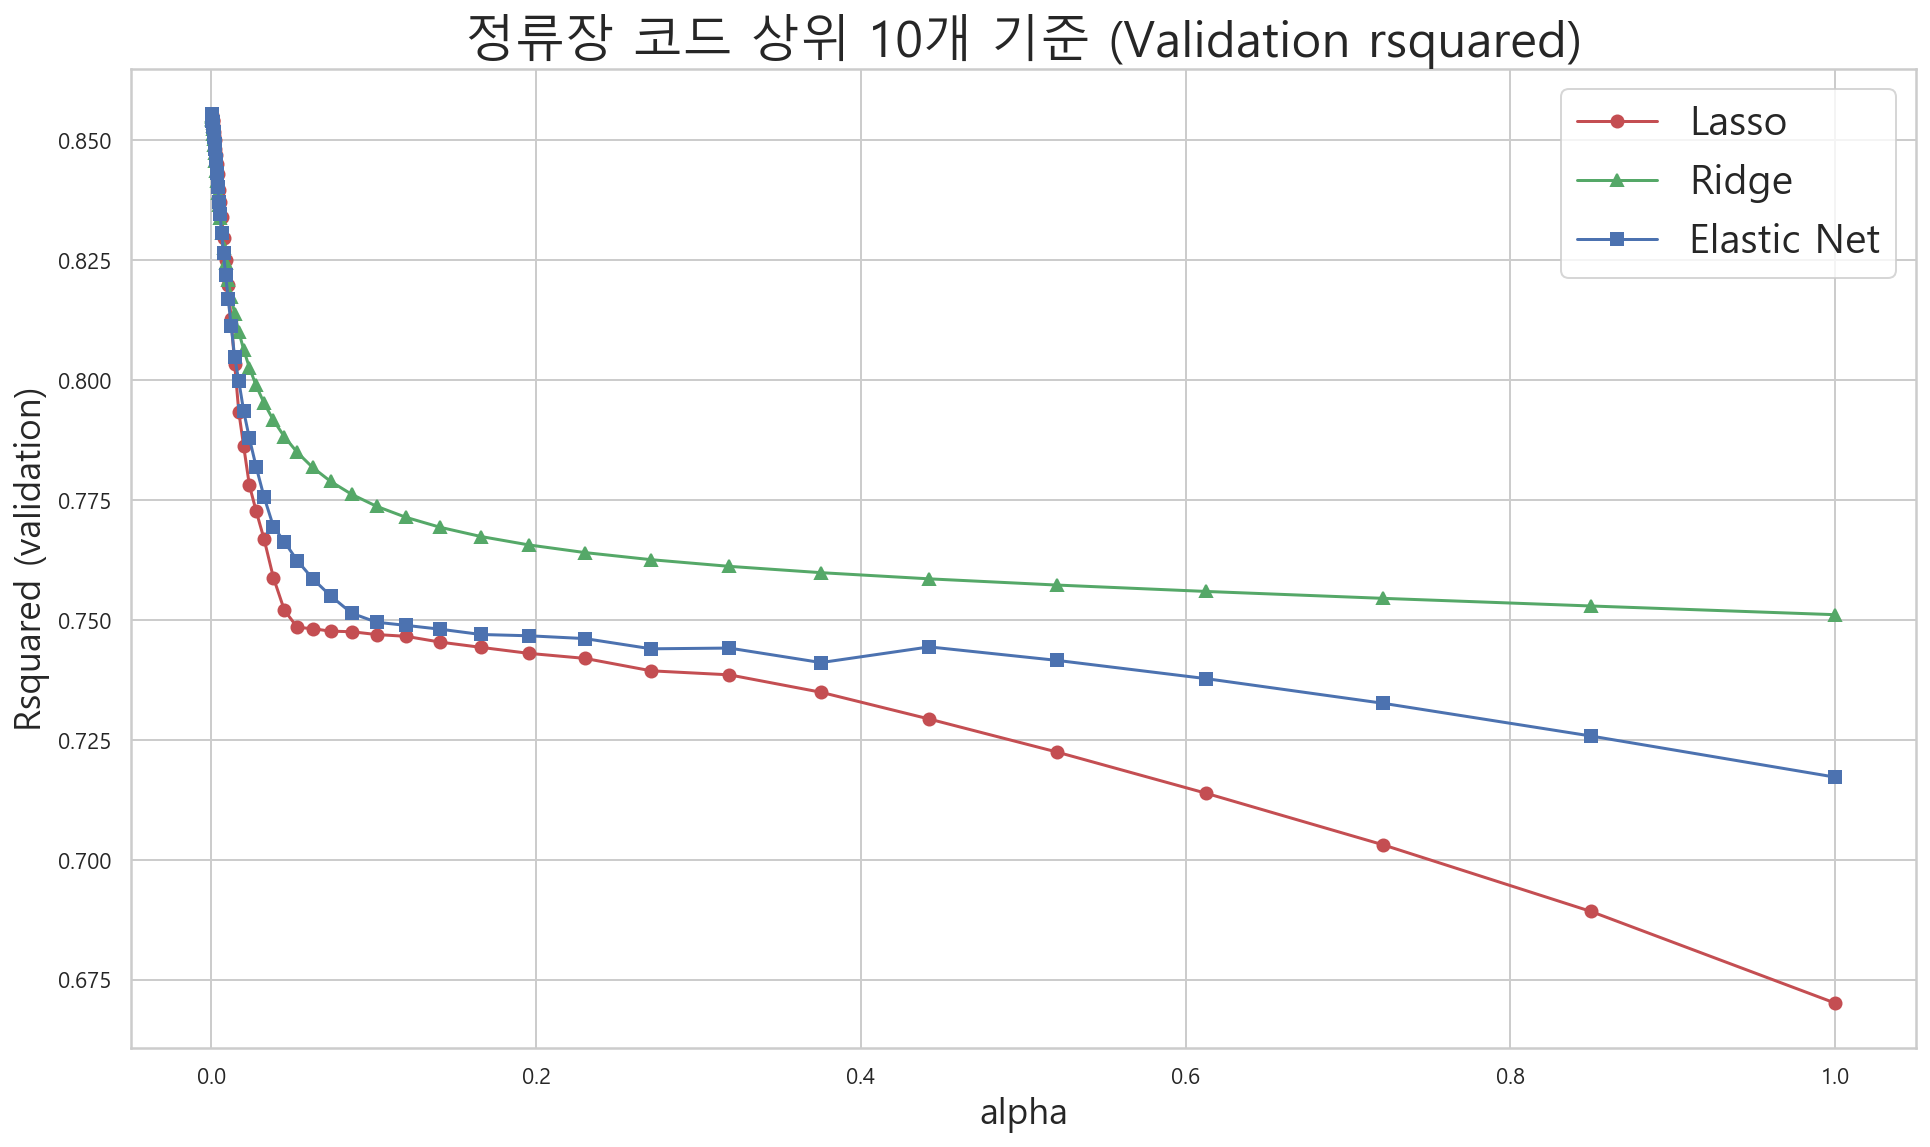

In [26]:
plt.figure(figsize=(16, 9))

idx = getalpha['alpha'].unique()
reg_lasso = getalpha[getalpha['name']=="lasso"]['val_score1']
lass = plt.plot(idx, reg_lasso, 'ro-', label="Lasso")

reg_ridge = getalpha[getalpha['name']=="ridge"]['val_score1']
ridge = plt.plot(idx, reg_ridge, 'g^-', label="Ridge")

reg_elastic = getalpha[getalpha['name']=="elastic"]['val_score1']
elastic = plt.plot(idx, reg_elastic, 'bs-', label="Elastic Net")

plt.legend(loc=1, fontsize=20)
plt.xlabel("alpha", fontsize=18)
plt.ylabel("Rsquared (validation)", fontsize=18)
plt.title("정류장 코드 상위 10개 기준 (Validation rsquared)", fontsize=25)
plt.grid(True)
plt.show()

#### 결론
- 제일 작은 단위의 알파값일때 검증의 r스퀘어가 높으므로, 정규화는 어려울듯 하다.

#### 06. vif, PCA 확인

In [27]:
# vif 확인
# 높은수는 PCA
scale_values.remove('scale_ride18')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    df_train[scale_values].values, i) for i in range(df_train[scale_values].shape[1])]
vif["features"] = df_train[scale_values].columns
vif.round(1)

,VIF Factor,features
0,978720.1,scale_ride6
1,79158.8,scale_ride7
2,1875948.5,scale_ride8
3,218555.2,scale_ride9
4,274179.1,scale_ride10
5,59324.3,scale_ride11
6,3076661.1,scale_off6
7,23853289.4,scale_off7
8,150404.0,scale_off8
9,5845946.5,scale_off9


In [28]:
# VIF 낮은값은 제외
scale_values.remove('scale_temperature')
scale_values.remove('scale_precipitation')
scale_values.remove('scale_bus_interval')
scale_values.remove('scale_bus_route_id_all_sum')
scale_values.remove('scale_bus_route_id_sum')
print(len(scale_values),'개의 컬럼을 PCA 합니다.')

40 개의 컬럼을 PCA 합니다.


In [29]:
# PCA 확인

def get_pca_data(ss_data, ss_test, n_components=2):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)
    pca.transform(ss_data)
    pca.transform(ss_test)
    return pca.transform(ss_data), pca.transform(ss_test), pca

def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_' + str(n) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [30]:
# vif에서 숫자가 높은 나온것들을 pca해보도록하자
# 40개의 컬럼을 6개로 PCA만듬.
ss_data = df_train[scale_values]
ss_test = df_test[scale_values]
df_train_pca, df_test_pca, pca = get_pca_data(ss_data,ss_test, n_components=6)
df_train_pca_pd = get_pd_from_pca(df_train_pca, pca.components_.shape[0])
df_test_pca_pd = get_pd_from_pca(df_test_pca, pca.components_.shape[0])

In [31]:
# pca는 원래데이터의 70%를 설명한다.
def print_variance_ratio(pca):
    print('variance_ratio: ', pca.explained_variance_ratio_)
    print('sum of variance_ratio: ', np.sum(pca.explained_variance_ratio_))
    
print_variance_ratio(pca)

variance_ratio:  [0.28928192 0.12218837 0.11152114 0.08467978 0.04371689 0.03939209]
sum of variance_ratio:  0.6907801936188285


In [32]:
# train 데이터에를 pca 합치고, 컬럼 생성
df_train_pca = df_train.copy()
df_train_pca_pd.index = df_train_pca.index
for i in range(0,6):
    df_train_pca[f'pca_{i}'] = df_train_pca_pd[f'pca_{i}']

In [33]:
# test 데이터에 pca 합치고, 컬럼 생성
df_test_pca = df_test.copy()
df_test_pca_pd.index = df_test_pca.index
for i in range(0,6):
    df_test_pca[f'pca_{i}'] = df_test_pca_pd[f'pca_{i}']

In [44]:
# pca_train를 500개의 정류장만 만들어봄
num = 500

table_raw = pd.pivot_table(raw_data, index='station_code', values='id', aggfunc=len,)
top = raw_data['station_code'].value_counts()[:num]
top_df = pd.DataFrame(top).reset_index()
top_df.columns = ['station_code', 'count']
print(f'상위 정류장 {num}개는 전체 3563개의 정류소 중', round(top_df['count'].sum() / len(raw_data) * 100,1),'%를 대표합니다.')

dataframe_pca = pd.DataFrame()
total = tqdm(top_df['station_code'].unique())
for i in total:
    dataframe_pca = dataframe_pca.append(df_train_pca[df_train_pca['station_code'] == i])

상위 정류장 500개는 전체 3563개의 정류소 중 57.0 %를 대표합니다.


In [45]:
# 여기서 변수 변경해가면서 검증해보세요
var_total = ['scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
             'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',
             'scale_temperature', 'scale_precipitation', 'scale_bus_interval', 
             'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
             'scale_ac_ride6', 'scale_ac_ride7', 'scale_ac_ride8', 'scale_ac_ride9', 'scale_ac_ride10', 'scale_ac_ride11',
             'scale_ac_off6', 'scale_ac_off7', 'scale_ac_off8', 'scale_ac_off9', 'scale_ac_off10', 'scale_ac_off11',
             'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011',
             'scale_ride_sum', 'scale_ac_ride_sum', 'scale_off_sum', 'scale_ac_off_sum',
             'scale_bus_route_id_sum','scale_bus_route_id_all_sum']

# 'scale_ride67','scale_ride89','scale_ride1011','scale_off67','scale_off89', 'scale_off1011'
# 는 2시간 더한 컬럼입니다.

# 검증에 사용할 실수 변수를 넣으세요
var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']
# 'scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
# 'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',

# 검증에 사용할 카테고리 변수를 넣으세요
cate = ['bus_route_id', 'in_', 'out', 'weekend', 'weekday', 'holiday', 'typhoon']

seeds = [300, 20, 30, 40, 50]  # 랜덤시드를 주어서 Kfold한 효과를 가져옴
test_size = 0.3  # 변경해도 상관은 없는데 그냥 0.3로 하는게.. 그래야 7.5:2.5 정도 나옵니다.
rsquared_df_pca = validations(dataframe_pca, seeds, test_size)#[basic + var + cate]
rsquared_df_pca

make_train_validation 실행중....



ols_validation 실행중....

seed : 300 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 20 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 30 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 40 완료


make_train_validation 실행중....



ols_validation 실행중....

seed : 50 완료


,seed,train_rsquared,validation_rsquared
0,300,0.786498,0.736100
0,20,0.779941,0.754646
0,30,0.776467,0.773089
0,40,0.791958,0.725509
0,50,0.779664,0.758738


#### 07. 전체 데이터로 확인
 - 함수 내에서 zero_df를 따로 생성하지 않습니다. 
 - 그러니 앞에 zero_df 생성하는 make_zero_raw_train 함수가 실행되어있어야 합니다.
 - 또한 zero_df의 변수명도 바뀌면 오류납니다.

In [36]:
# 나뉘어진 트레인과 테스트를 입력받아서, 정류장별 학습 및 예측 하면됨
# 최종 테스트

def ols_final(df_train, df_test, var, cate):

    total = tqdm(df_train['station_code'].unique())
    columns = df_train.columns
    df_tr = pd.DataFrame(columns=columns)
    df_te = pd.DataFrame(columns=columns)
    df_tr['yhat'] = 999
    df_te['yhat'] = 999
    cate_c = [f"C({name})" for name in cate]
    y = ['scale_ride18']
    for i in total:
        train_ols = df_train[df_train['station_code'] == i]
        test_ols = df_test[df_test['station_code'] == i]

        if i in zero_df['station_code'].unique():
            
            test_ols['yhat'] = zero_df[zero_df['station_code'] == i]['scale_ride18']
            df_tr = pd.concat([df_tr, test_ols])
            df_te = pd.concat([df_te, test_ols])

        elif len(test_ols) == 0:
            model = sm.OLS.from_formula(
                'scale_ride18  ~ ' + '+'.join(var)
                + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit()
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])

        else:
            model = sm.OLS.from_formula(
                'scale_ride18  ~ ' + '+'.join(var)
                + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit()
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])

            test_ols_df = test_ols[var+cate]  # 테스트 모델
            test_ols['yhat'] = result.predict(test_ols_df)
            df_te = pd.concat([df_te, test_ols])
    return df_tr, df_te

In [37]:
# 전처리 하기전 R스퀘어

basic = ['scale_ride18', 'station_code']
var = ['scale_ride6', 'scale_ride7', 'scale_ride8', 'scale_ride9', 'scale_ride10', 'scale_ride11',
       'scale_off6', 'scale_off7', 'scale_off8', 'scale_off9', 'scale_off10', 'scale_off11',]

cate = ['bus_route_id'] 

df_tr, df_te = ols_final(df_train[basic + var + cate], df_test[basic + var + cate], var, cate)
get_rsquared(df_tr, df_te,0)


seed : 0 완료


,seed,train_rsquared,validation_rsquared
0,0,0.772001,0.620312


In [38]:
# 전처리 후 R스퀘어(PCA전)

basic = ['scale_ride18', 'station_code']

var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_ride_sum', 'scale_off_sum', 'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'scale_ride67', 'scale_ride89', 'scale_ride1011', 'scale_off67', 'scale_off89', 'scale_off1011',
       'scale_ac_ride67', 'scale_ac_ride89', 'scale_ac_ride1011', 'scale_ac_off67', 'scale_ac_off89', 'scale_ac_off1011'
       ]

cate = ['bus_route_id', 'in_', 'out', 'weekend', 'weekday', 'holiday', 'typhoon']

df_tr2, df_te2 = ols_final(df_train[basic + var + cate], df_test[basic + var + cate], var, cate)
get_rsquared(df_tr2, df_te2,0)


seed : 0 완료


,seed,train_rsquared,validation_rsquared
0,0,0.796756,0.695895


In [39]:
# PCA 전체 모델
basic = ['scale_ride18', 'station_code']

var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']

cate = ['bus_route_id', 'typhoon','in_', 'out', 'weekend', 'weekday', 'holiday']  

df_tr_pca, df_te_pca = ols_final(df_train_pca[basic + var + cate], df_test_pca[basic + var + cate], var, cate)
get_rsquared(df_tr_pca, df_te_pca,0)


seed : 0 완료


,seed,train_rsquared,validation_rsquared
0,0,0.782146,0.72872


#### 09. 대표모델
 - 데이터가 제일 많은 정류장 1곳의 모델 확인

In [46]:
# 데이터가 제일 많은 정류장 
top = pd.concat([df_train_pca, df_test_pca])
top_station = top['station_code'].value_counts()[:1].reset_index()
top_station.columns = ['station_code', 'count']
for i in top_station['station_code']:
    top_station_df = top[top['station_code'] == i]
top_station_df.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67,ride89,ride1011,off67,off89,off1011,ac_ride67,ac_ride89,ac_ride1011,ac_off67,ac_off89,ac_off1011,ride_sum,ac_ride_sum,off_sum,ac_off_sum,bus_route_id_sum,bus_route_id_all_sum,scale_ride6,scale_ride7,scale_ride8,scale_ride9,scale_ride10,scale_ride11,scale_off6,scale_off7,scale_off8,scale_off9,scale_off10,scale_off11,scale_ride18,scale_temperature,scale_precipitation,scale_bus_interval,scale_ride67,scale_ride89,scale_ride1011,scale_off67,scale_off89,scale_off1011,scale_ac_ride6,scale_ac_ride7,scale_ac_ride8,scale_ac_ride9,scale_ac_ride10,scale_ac_ride11,scale_ac_off6,scale_ac_off7,scale_ac_off8,scale_ac_off9,scale_ac_off10,scale_ac_off11,scale_ac_ride67,scale_ac_ride89,scale_ac_ride1011,scale_ac_off67,scale_ac_off89,scale_ac_off1011,scale_ride_sum,scale_ac_ride_sum,scale_off_sum,scale_ac_off_sum,scale_bus_route_id_sum,scale_bus_route_id_all_sum,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5
362754,362754,2019-09-27,23590000,시내,358,한라병원,33.48963,126.486,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.632696,26.401464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,제주특별자치도 제주시 연동 250,제주시,제주시,연동,제원1길,제주,23.8,36.0,20.0,27,4,Friday,0.0,1.0,0,0,1,0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,2.0,1.0,59,1610,0.637405,1.455211,-0.348594,-0.325571,-0.314778,-0.298384,1.483069,0.524618,-0.308228,-0.288850,-0.286501,-0.277418,-0.261337,-0.154172,0.686745,-0.442685,1.392232,-0.388596,-0.349721,1.017675,-0.351784,-0.321638,-0.26919,-0.367766,-0.359957,-0.342967,-0.32708,-0.312099,-0.178961,-0.265612,-0.316219,0.370720,-0.30211,-0.292509,-0.395633,-0.407685,-0.36601,-0.289381,0.010045,-0.339932,0.163249,-0.46479,-0.028768,-0.225804,3.623411,3.382591,-0.679970,-1.011249,0.046876,-0.610846,1.701832,2.019481
110041,110041,2019-09-09,21480000,시내,358,한라병원,33.48963,126.486,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,6.0,6.0,2.0,0.0,3.632696,26.401464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,제주특별자치도 제주시 연동 250,제주시,제주시,연동,제원1길,제주,26.2,24.7,49.0,9,0,Monday,1.0,0.0,0,0,1,0,0.0,0.0,1.0,0.0,12.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,20.0,1.0,57,1610,-0.272041,-0.364161,-0.348594,-0.325571,0.223733,-0.298384,-0.186965,-0.265886,3.389972,3.866848,4.022762,1.132043,-0.261337,1.212972,0.292569,-0.311774,-0.392570,-0.388596,-0.045613,-0.294018,4.251139,2.924935,-0.26919,-0.367766,-0.359957,-0.342967,-0.32708,-0.312099,-0.178961,-0.265612,0.283690,-0.298294,-0.30211,-0.292509,-0.395633,-0.407685,-0.36601,-0.289381,0.010045,-0.339932,-0.325163,-0.46479,3.249113,-0.225804,3.463028,3.382591,2.554424,-3.375067,4.474584,4.678477,-1.970009,-1.616175


In [47]:
# 트레인 테스트 나누기
top_train, top_test = make_train_validation(top_station_df,cate, 0.2, 13)
len(top_train), len(top_test)

make_train_validation 실행중....



(1349, 261)

In [48]:
# 모델 돌리고 summary()확인
var = ['scale_temperature', 'scale_precipitation', 'scale_bus_interval',
       'scale_bus_route_id_sum', 'scale_bus_route_id_all_sum',
       'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']

cate = ['bus_route_id', 'in_', 'out', 'weekend', 'weekday', 'holiday', 'typhoon']
cate_c = [f"C({name})" for name in cate]
model = sm.OLS.from_formula(
                'scale_ride18  ~ ' + '+'.join(var)
                + '+'.join('+') + '+'.join(cate_c), data=top_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           scale_ride18   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     79.15
Date:                Fri, 17 Apr 2020   Prob (F-statistic):               0.00
Time:                        04:22:35   Log-Likelihood:                -1579.8
No. Observations:                1349   AIC:                             3346.
Df Residuals:                    1256   BIC:                             3830.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [49]:
# 예측값 확인
pred = result.predict(top_test)
rsquared = r2_score(top_test.scale_ride18, pred)
round(rsquared,2)

0.83

# zero model 확인
 - 우리가 가지고있는 Data로 말고, 실제 외부데이터가 들어왔다는 가정일때
 - 실제 test 모델 검증중엔 안해도 됩니다. 그냥 데이콘에 제출할수 있을까해서 만든거에요
 - 얘는 yhat을 scale이 안된값을 출력해야해서 합니다..포뮬라식에서 y가 ride_18 입니다

In [ ]:
# 실제 train 데이터를 입력받아서, zero_df를 만들고 실행합니다.
def ols_final_dacon(df_train, df_test, var, cate):

    columns = df_train.columns
    df_tr = pd.DataFrame(columns=columns)
    df_te = pd.DataFrame(columns=columns)
    df_tr['yhat'] = 999
    df_te['yhat'] = 999
    cate_c = [f"C({name})" for name in cate]
    y = ['ride18']
    
    # 입력받은 train 데이터에서 zero_model 생성
    # 입력받은 train은 우리가 임의로 나눈 데이터가 아니여도 zero_model이 있을수 있으므로 생성
    # 위에서 raw_data에서 뺸 zero_model은 검증을 위해 제외한것, 그것을 전체데이터를 검증하는 곳에 넣었으니
    # 여기서입력받는 df_train에는 위에서 제외시킨 zero_model이 포함되어야 함
    table = pd.pivot_table(index='station_code', data=df_train, values='id', aggfunc=len).reset_index()
    table = table[table['id'] == 1]
    raw_train = df_train.copy()
    raw_zero =pd.DataFrame(columns=df_train.columns)
    
    for i in table['station_code'].unique():
        raw_train = raw_train[raw_train['station_code'] != i]
        raw_zero = raw_zero.append(raw_data[raw_data['station_code'] == i])
    # zero 모델의 df 생성
    a = raw_zero[['station_code','ride18']]
    zero_df = pd.merge(table, a, how = 'inner')
    
    total = tqdm(df_test['station_code'].unique())
    for i in total:
        train_ols = df_train[df_train['station_code'] == i]
        test_ols = df_test[df_test['station_code'] == i]

        if i in zero_df['station_code'].unique():
            
            test_ols['yhat'] = zero_df[zero_df['station_code'] == i]['ride18']
            df_tr = pd.concat([df_tr, test_ols])
            df_te = pd.concat([df_te, test_ols])

        elif len(test_ols) == 0:
            model = sm.OLS.from_formula(
                'ride18  ~ ' + '+'.join(var)
                + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit()
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])

        else:
            model = sm.OLS.from_formula(
                'ride18  ~ ' + '+'.join(var)
                + '+'.join('+') + '+'.join(cate_c), data=train_ols)
            # 학습
            result = model.fit()
            # 결과
            train_ols['yhat'] = result.predict(train_ols)
            # 학습 저장
            df_tr = pd.concat([df_tr, train_ols])

            test_ols_df = test_ols[var+cate]  # 테스트 모델
            test_ols['yhat'] = result.predict(test_ols_df)
            df_te = pd.concat([df_te, test_ols])
    return df_tr, df_te

In [ ]:
# zero model만 돌리기

var = ['ride6', 'ride7', 'ride8', 'ride9', 'ride10', 'ride11',
       'off6', 'off7', 'off8', 'off9', 'off10', 'off11',
       'temperature', 'precipitation', 'bus_interval',
       'ride_sum', 'off_sum']
cate = ['bus_route_id', 'in_', 'out','weekend', 'weekday', 'holiday', 'typhoon']
df_tr2, df_te2 = ols_final_dacon(raw_zero, raw_zero,var,cate)

In [ ]:
# zero model을 포함한것 돌리기 (실제 외부데이터가 들어왔다는 가정으로)
# df_train = train data
# df_test = test data (zero_df 제외)
# zero_df = 1회만 운행된 정류소(예측모델 생성 완전히 불가)
# tm = df_train + zero_df (zero model 확인용으로 사용, 실제 모델은 df_train, df_test를 사용하면 됨)외부 데이터인것으로 가정
# im = df_test + zero_df (zero model 확인용으로 사용, 실제 모델은 df_train, df_test를 사용하면 됨)외부 데이터인것으로 가정

tm = pd.concat([raw_zero, df_train])
im = pd.concat([raw_zero, df_test])

df_tr2, df_te2 = ols_final_dacon(tm, im, var, cate)

In [ ]:
get_rsquared(df_tr2, df_te2,0)